In [ ]:
import os
import pandas as pd
import numpy as np

import string
import re

from math import nan
from future.utils import iteritems

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "darkgrid")

%tensorflow_version 1.x

!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn_crfsuite
!pip install seqeval
#!pip install modin

import keras as k
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras.utils import plot_model


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

TensorFlow 1.x selected.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-gfnm7_ke
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-gfnm7_ke
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=05f870c7567f1a8c63a471528e0a63efd9a537fa0a9875ed590bf1cf8983ce81
  Stored in directory: /tmp/pip-ephem-wheel-cache-7tf0ttls/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 747kB 3.9MB/s 
     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=5ca796ed84703cea4774291b3e6b801d7bd335fa8d3316b360e06bc7fe5fe829
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4P_I6M_TIbbzep6Awgsfl_EgSdY7VouvVLP50Fhbf1LvMZBQxstXY
Mounted at /content/gdrive/


In [ ]:
cd gdrive/MyDrive/coursework

/content/gdrive/MyDrive/coursework


In [ ]:
from scienceie_loader import load_tokenized_data, load_data_with_char_offsets, get_entity_span_from_B_index

In [ ]:
data_root = os.path.join(os.getcwd(), 'original_datasets')
data_train = os.path.join(data_root, 'scienceie2017_train/train2')
data_dev = os.path.join(data_root, 'scienceie2017_dev/dev')
data_test = os.path.join(data_root, 'semeval_articles_test')

In [ ]:
train_docs, train_rels, _ = load_tokenized_data(data_train)
dev_docs, dev_rels, _ = load_tokenized_data(data_dev)
test_docs, test_rels, _ = load_tokenized_data(data_test)

In [ ]:
train_docs_chars = load_data_with_char_offsets(data_train)
test_docs_chars = load_data_with_char_offsets(data_test)
dev_docs_chars = load_data_with_char_offsets(data_dev)

In [ ]:
train = [j for i in train_docs for j in i]
dev = [j for i in dev_docs for j in i]
test = [j for i in test_docs for j in i]

In [ ]:
train_dataset = pd.DataFrame(train, columns = ["Words", "Tags"])
test_dataset = pd.DataFrame(test, columns = ["Words", "Tags"]) 
dev_dataset = pd.DataFrame(dev, columns = ["Words", "Tags"]) 

In [ ]:
train_dataset.head()

,Words,Tags
0,A,O
1,fuzzy-Hammerstein,B-Task
2,model,I-Task
3,predictive,I-Task
4,control,I-Task


In [ ]:
train_dataset["Words"] = train_dataset["Words"].str.lower()

In [ ]:
cd /content/gdrive/MyDrive/coursework/glove.6B/glove.6B.300d.txt

[Errno 20] Not a directory: '/content/gdrive/MyDrive/coursework/glove.6B/glove.6B.300d.txt'
/content/gdrive/MyDrive/coursework


In [ ]:
GLOVE_DIR = "/content/gdrive/MyDrive/coursework/glove.6B/glove.6B.300d.txt"

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        w_to_vec_m = {}
        for line in f:
            line = line.strip().split()
            curr = line[0]
            words.add(curr)
            w_to_vec_m[curr] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        w_to_i = {}
        i_to_w = {}
        for w in sorted(words):
            w_to_i[w] = i
            i_to_w[i] = w
            i = i + 1
    return w_to_i, i_to_w, w_to_vec_m

w_to_i, i_to_w, w_to_vec_m = read_glove_vecs(GLOVE_DIR)
print(len(w_to_vec_m))

400000


In [ ]:
train_datase = pd.DataFrame(train, columns = ["Words", "Tags"])
dev_datase = pd.DataFrame(dev, columns = ["Words", "Tags"])
test_datase = pd.DataFrame(test, columns = ["Words", "Tags"])

In [ ]:
train_dataset.head()

,Words,Tags
0,a,O
1,fuzzy-hammerstein,B-Task
2,model,I-Task
3,predictive,I-Task
4,control,I-Task


In [ ]:
train_dataset["Tags"].unique()

array(['O', 'B-Task', 'I-Task', 'B-Material', 'I-Material', 'B-Process',
       'I-Process'], dtype=object)

In [ ]:
labels = {
    "B-Task" : "Task",
    "I-Task" : "Task",
    "O" : "O",
    "B-Process" : "Process",
    "I-Process" : "Process",
    "B-Material" : "Material",
    "I-Material" : "Material",
}

In [ ]:
train_dataset['Words'] = train_dataset['Words'].str.lower()
#train_dataset['Tags'] = train_dataset['Tags'].map(labels)

In [ ]:
train_dataset.head()

,Words,Tags
0,a,O
1,fuzzy-hammerstein,B-Task
2,model,I-Task
3,predictive,I-Task
4,control,I-Task


In [ ]:
from itertools import chain
count_tags = {}
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(train_dataset['Words'].to_list()))
    else:
        vocab = list(set(train_dataset['Tags'].to_list()))
        for i in vocab:
            if i not in count_tags:
                count_tags[i]=0
        for i in train_dataset['Tags'].to_list():
            count_tags[i] += 1
            
    for i in count_tags:
        print(i, count_tags[i])
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
        
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(train_dataset, 'token')
tag2idx, idx2tag = get_dict_map(train_dataset, 'tag')

I-Task 4294
O 43849
B-Material 2185
I-Material 2563
I-Process 5705
B-Task 1100
B-Process 2779


In [ ]:
train_dataset['Word_idx'] = train_dataset['Words'].map(w_to_i)
train_dataset['Tag_idx'] = train_dataset['Tags'].map(tag2idx)
train_dataset.head()

,Words,Tags,Word_idx,Tag_idx
0,a,O,43010.0,1
1,fuzzy-hammerstein,B-Task,NaN,5
2,model,I-Task,247378.0,0
3,predictive,I-Task,291292.0,0
4,control,I-Task,108302.0,0


In [ ]:
len(train_dataset)

62475

In [ ]:
train_dataset["Tag_idx"].unique()

array([5, 2, 6, 0, 1, 4, 3])

In [ ]:
r = []
for i in range(len(train_docs)):
  x = len(train_docs[i])
  for j in range(x):
    r.append(i+1)

In [ ]:
train_dataset["Sentence_idx"] = r

In [ ]:
train_dataset

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,nuclear,B-Task,265375.0,5,1
1,theory,I-Task,357607.0,2,1
2,devoted,O,122590.0,6,1
3,major,O,231345.0,6,1
4,efforts,O,133951.0,6,1
...,...,...,...,...,...
62470,smooth,O,335514.0,6,350
62471,and,O,54718.0,6,350
62472,nonsmooth,O,NaN,6,350
62473,data,O,117493.0,6,350


In [ ]:
train_dataset[train_dataset["Words"] == "another"]

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
3034,another,O,56041.0,6,15
10201,another,O,56041.0,6,53
12224,another,B-Process,56041.0,0,63
13506,another,O,56041.0,6,69
21391,another,O,56041.0,6,109
30202,another,O,56041.0,6,152
32381,another,I-Task,56041.0,2,163
35031,another,O,56041.0,6,177
38737,another,O,56041.0,6,198
38894,another,O,56041.0,6,199


In [ ]:
#train_dataset.drop_duplicates(["Words", "Tags"], inplace = True)

In [ ]:
train_dataset[train_dataset["Words"] == "another"]

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
3034,another,O,56041.0,6,15
10201,another,O,56041.0,6,53
12224,another,B-Process,56041.0,0,63
13506,another,O,56041.0,6,69
21391,another,O,56041.0,6,109
30202,another,O,56041.0,6,152
32381,another,I-Task,56041.0,2,163
35031,another,O,56041.0,6,177
38737,another,O,56041.0,6,198
38894,another,O,56041.0,6,199


In [ ]:
train_dataset.head()

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,nuclear,B-Task,265375.0,5,1
1,theory,I-Task,357607.0,2,1
2,devoted,O,122590.0,6,1
3,major,O,231345.0,6,1
4,efforts,O,133951.0,6,1


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62475 entries, 0 to 62474
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Words         62475 non-null  object 
 1   Tags          62475 non-null  object 
 2   Word_idx      58705 non-null  float64
 3   Tag_idx       62475 non-null  int64  
 4   Sentence_idx  62475 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 2.4+ MB


In [ ]:
train_dataset.isna().sum()

Words              0
Tags               0
Word_idx        3770
Tag_idx            0
Sentence_idx       0
dtype: int64

In [ ]:
train_dataset[(train_dataset["Word_idx"].isna()) & (train_dataset["Tags"] == "Process")]

,Words,Tags,Word_idx,Tag_idx,Sentence_idx


In [ ]:
for i in range(len(train_dataset["Words"])):
  if train_dataset["Words"][i].endswith("ing"):
    train_dataset["Tags"][i] = "O"

In [ ]:
for i in train_dataset["Words"]:
  if i.endswith("ing"):
    print(i)

In [ ]:
test_dataset.head()

,Words,Tags
0,Three-dimensional,B-Process
1,digital,I-Process
2,subtraction,I-Process
3,angiographic,I-Process
4,(,O


In [ ]:
data_fillna = train_dataset.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(
['Sentence_idx'],as_index=False)[['Words', 'Tags', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))
data_group.head()

,Sentence_idx,Words,Tags,Word_idx,Tag_idx
0,1,"[nuclear, theory, devoted, major, efforts, sin...","[B-Task, I-Task, O, O, O, O, O, O, O, O, B-Pro...","[265375.0, 357607.0, 122590.0, 231345.0, 13395...","[5, 2, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 0, 1, 6, ..."
1,2,"[the, particular, phase, field, model, we, emp...","[O, O, B-Task, I-Task, I-Task, O, O, O, O, O, ...","[357266.0, 278014.0, 283048.0, 147810.0, 24737...","[6, 6, 5, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,3,"[to, conclude, ,, the, electrochemical, reduct...","[O, O, O, O, B-Task, I-Task, I-Task, I-Task, I...","[360915.0, 106803.0, 452.0, 357266.0, 135160.0...","[6, 6, 6, 6, 5, 2, 2, 2, 2, 6, 4, 3, 6, 6, 6, ..."
3,4,"[the, validity, of, semi-classical, boundary, ...","[O, B-Task, I-Task, I-Task, I-Task, I-Task, O,...","[357266.0, 375441.0, 268046.0, 324517.0, 81903...","[6, 5, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
4,5,"[in, contrast, with, polymers, ,, which, are, ...","[O, O, O, B-Material, O, O, O, O, B-Process, I...","[188481.0, 108256.0, 388711.0, 288221.0, 452.0...","[6, 6, 6, 4, 6, 6, 6, 6, 0, 1, 1, 1, 1, 6, 4, ..."


In [ ]:
len(data_group)

350

In [ ]:
data_group

,Sentence_idx,Words,Tags,Word_idx,Tag_idx
0,1,"[nuclear, theory, devoted, major, efforts, sin...","[B-Task, I-Task, O, O, O, O, O, O, O, O, B-Pro...","[265375.0, 357607.0, 122590.0, 231345.0, 13395...","[5, 2, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 0, 1, 6, ..."
1,2,"[the, particular, phase, field, model, we, emp...","[O, O, B-Task, I-Task, I-Task, O, O, O, O, O, ...","[357266.0, 278014.0, 283048.0, 147810.0, 24737...","[6, 6, 5, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,3,"[to, conclude, ,, the, electrochemical, reduct...","[O, O, O, O, B-Task, I-Task, I-Task, I-Task, I...","[360915.0, 106803.0, 452.0, 357266.0, 135160.0...","[6, 6, 6, 6, 5, 2, 2, 2, 2, 6, 4, 3, 6, 6, 6, ..."
3,4,"[the, validity, of, semi-classical, boundary, ...","[O, B-Task, I-Task, I-Task, I-Task, I-Task, O,...","[357266.0, 375441.0, 268046.0, 324517.0, 81903...","[6, 5, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
4,5,"[in, contrast, with, polymers, ,, which, are, ...","[O, O, O, B-Material, O, O, O, O, B-Process, I...","[188481.0, 108256.0, 388711.0, 288221.0, 452.0...","[6, 6, 6, 4, 6, 6, 6, 6, 0, 1, 1, 1, 1, 6, 4, ..."
...,...,...,...,...,...
345,346,"[a, popular, choice, is, to, couple, a, set, o...","[O, O, O, O, O, B-Process, I-Process, I-Proces...","[43010.0, 288917.0, 99771.0, 192973.0, 360915....","[6, 6, 6, 6, 6, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
346,347,"[the, boundary, element, method, (, bem, ), ha...","[O, B-Process, I-Process, I-Process, O, B-Proc...","[357266.0, 81903.0, 135301.0, 242245.0, 158.0,...","[6, 0, 1, 1, 6, 0, 6, 6, 6, 6, 6, 6, 6, 5, 2, ..."
347,348,"[experimental, studies, of, the, dynamics, of,...","[O, O, O, O, O, O, O, B-Material, I-Material, ...","[142820.0, 345173.0, 268046.0, 357266.0, 13166...","[6, 6, 6, 6, 6, 6, 6, 4, 3, 6, 4, 6, 6, 6, 6, ..."
348,349,"[in, all, these, studies, ,, the, association,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[188481.0, 51582.0, 357761.0, 345173.0, 452.0,...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."


In [ ]:
#words_train = list(set(train_dataset["Words"].values))
words_train = list(data_group["Words"].values)
n_words_train = len(words_train)

tags_train = []
for tag_train in data_group["Tags"]:
  if tag_train is nan or isinstance(tag_train, float):
    tags_train.append("Unknown")
  else:
    tags_train.append(tag_train)

n_tags_train  = len(tags_train)

In [ ]:

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Words'].to_list())))
    
    print(n_token)
    n_tag = len(list(set(data['Tags'].to_list())))
    print(n_tag)
    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    print(tokens)
    #maxlen = max([len(s) for s in tokens])
    maxlen = 344
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    print(pad_tokens)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes = n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    
    #train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)


    return pad_tokens, pad_tags
"""
"""
 #   print(
  #      'train_tokens length:', len(train_tokens),
   #     '\ntrain_tokens length:', len(train_tokens),
    #    '\nval_tokens:', len(val_tokens),
     #   '\nval_tags:', len(val_tags),
    #) # 
    

train_tokens, train_tags = get_pad_train_test_val(data_group, train_dataset)

9446
7
[[265375.0, 357607.0, 122590.0, 231345.0, 133951.0, 332240.0, 26559.0, 118593.0, 360915.0, 121730.0, 121730.0, 188481.0, 265375.0, 302195.0, 452.0, 291311.0, 374253.0, 324517.0, 242260.0, 42972.0, 42972.0, 42974.0, 452.0, 188481.0, 222946.0, 388711.0, 332008.0, 292803.0, 188481.0, 297180.0, 223495.0, 42972.0, 42972.0, 42974.0, 867.0, 357640.0, 385664.0, 62699.0, 360915.0, 122447.0, 188387.0, 248029.0, 131666.0, 242260.0, 105593.0, 297180.0, 146160.0, 388711.0, 43010.0, 324501.0, 102223.0, 364480.0, 268046.0, 131664.0, 109507.0, 42972.0, 42972.0, 42974.0, 867.0, 343257.0, 452.0, 262350.0, 102473.0, 297180.0, 57920.0, 192973.0, 302229.0, 63822.0, 393705.0, 452.0, 188481.0, 339693.0, 268046.0, 265603.0, 151725.0, 62699.0, 42972.0, 42972.0, 42974.0, 867.0, 357266.0, 147810.0, 268046.0, 103318.0, 54718.0, 256277.0, 344940.0, 192973.0, 144971.0, 394534.0, 87775.0, 145460.0, 122454.0, 188481.0, 304963.0, 360915.0, 357266.0, 270157.0, 122459.0, 268046.0, 217676.0, 54718.0, 187682.0, 187

In [ ]:
print(len(train_tokens))

350


In [ ]:
train_tokens.shape

(350, 344)

In [ ]:
print(len(train_tags))

350


In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed
#seed(1)
#tensorflow.random.set_seed(2)

input_dim = len(list(set(train_dataset['Words'].to_list())))+1

output_dim = 64
input_length = 344
#input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  9447 
output_dim:  64 
input_length:  344 
n_tags:  7


In [ ]:
class make_sentence(object):

  def __init__(self, dataset):
    self.sent = 1
    self.dataset = dataset
    self.empty = False
    func = lambda s : [(word, tag) for word, tag in zip(s["Words"].values.tolist(),
                                                        s["Tags"].values.tolist())]
    self.group = self.dataset.groupby("Sentence_idx").apply(func)
    self.sentences = [s for s in self.group]

  
  def get_max(self):
    try:
      s = self.group["Sentence : {}".format(self.sent)]
      self.sent += 1
      return s
    except :
      return None

In [ ]:
getter = make_sentence(train_dataset)
sentences_train = getter.sentences

In [ ]:
"""
maxlen_train = 344

X_train = [[w_to_i[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen = maxlen_train, sequences = X_train, padding = "post",value = n_words_train - 1)

Y_train = [[tag2idx_train[w[1]] for w in s] for s in sentences_train]
Y_train = pad_sequences(maxlen = maxlen_train, sequences = Y_train, padding = "post", value = 6)
Y_train = [to_categorical(i, num_classes = n_tags_train) for i in Y_train]
"""

'\nmaxlen_train = 344\n\nX_train = [[w_to_i[w[0]] for w in s] for s in sentences_train]\nX_train = pad_sequences(maxlen = maxlen_train, sequences = X_train, padding = "post",value = n_words_train - 1)\n\nY_train = [[tag2idx_train[w[1]] for w in s] for s in sentences_train]\nY_train = pad_sequences(maxlen = maxlen_train, sequences = Y_train, padding = "post", value = 6)\nY_train = [to_categorical(i, num_classes = n_tags_train) for i in Y_train]\n'

In [ ]:
"""
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
"""

"\ndef train_model(X, y, model):\n    loss = list()\n    for i in range(25):\n        # fit model for one epoch on this sequence\n        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)\n        loss.append(hist.history['loss'][0])\n    return loss\n"

In [ ]:
# Embedding Layer

import keras as k
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


input = Input(shape = (344, ))
word_embedding_size = 210

model = Embedding(input_dim = input_dim, output_dim = 210, input_length = 344)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units = word_embedding_size, activation = "tanh", recurrent_activation =  "sigmoid", 
                           use_bias = True, kernel_initializer = k.initializers.he_normal(),
                           recurrent_initializer = "orthogonal", bias_initializer = "zeros", return_sequences = True,
                           recurrent_dropout = 0.5, dropout = 0.5))(model)

model = LSTM(units = word_embedding_size * 2, activation = "tanh", recurrent_activation =  "sigmoid", 
                           use_bias = True, kernel_initializer = k.initializers.he_normal(),
                           recurrent_initializer = "orthogonal", bias_initializer = "zeros", return_sequences = True,
                           recurrent_dropout = 0.5, dropout = 0.5)(model)

                           


# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation = "relu"))(model)     #use_bias

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
print("----------------------")
print(out)
print("----------------------")
model = Model(input, out)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
----------------------
Tensor("crf_1/cond/Merge:0", shape=(?, 344, 7), dtype=float32)
----------------------


In [ ]:
adam = k.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.9, beta_2 = 0.999)

# Compile model
model.compile(optimizer = adam, loss = crf.loss_function,sample_weight_mode = None , 
              metrics = [crf.accuracy, 'accuracy'], target_tensors = None)

model.summary()

# Saving the best model only
file_path = "TA-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(file_path, period = 1, monitor = 'val_accuracy', verbose = 1, save_best_only = True, 
                             save_weights_only = False, mode = "max")     #max --> auto

callbacks_list = [checkpoint]

# Fit the best model
#model_fitting = model.fit(train_tokens, np.array(train_tags), batch_size = 1000, validation_split = 0.2, epochs = 4,
                    #      verbose = 1, callbacks = callbacks_list, shuffle = True, initial_epoch = 0, 
                     #     max_queue_size = 10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 344)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 344, 210)          1983870   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 344, 420)          707280    
_________________________________________________________________
lstm_2 (LSTM)                (None, 344, 420)          1412880   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 344, 7)            2947      
_________________________________________________________________
crf_1 (CRF)                  (None, 344, 7)            119       
Total params: 4,107,096
Trainab

In [ ]:
"""
model_fitting = model.fit(train_tokens, np.array(train_tags), batch_size = 1000, validation_split = 0.2, epochs = 4,
                          verbose = 1, callbacks = callbacks_list, shuffle = True, initial_epoch = 0, 
                          max_queue_size = 10)
"""

'\nmodel_fitting = model.fit(train_tokens, np.array(train_tags), batch_size = 1000, validation_split = 0.2, epochs = 4,\n                          verbose = 1, callbacks = callbacks_list, shuffle = True, initial_epoch = 0, \n                          max_queue_size = 10)\n'

In [ ]:
train = [j for i in train_docs for j in i]
dev = [j for i in dev_docs for j in i]
test = [j for i in test_docs for j in i]

In [ ]:
train_dataset = pd.DataFrame(train, columns = ["Words", "Tags"])
test_dataset = pd.DataFrame(test, columns = ["Words", "Tags"])
dev_dataset = pd.DataFrame(dev, columns = ["Words", "Tags"])

In [ ]:
train_dataset.head()

,Words,Tags
0,Nuclear,B-Task
1,theory,I-Task
2,devoted,O
3,major,O
4,efforts,O


In [ ]:
from itertools import chain
count_tags = {}
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(train_dataset['Words'].to_list()))
    else:
        vocab = list(set(train_dataset['Tags'].to_list()))
        for i in vocab:
            if i not in count_tags:
                count_tags[i]=0
        for i in train_dataset['Tags'].to_list():
            count_tags[i] += 1
            
    for i in count_tags:
        print(i, count_tags[i])
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
        
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(train_dataset, 'token')
tag2idx, idx2tag = get_dict_map(train_dataset, 'tag')

B-Process 2779
I-Process 5705
I-Task 4294
I-Material 2563
B-Material 2185
B-Task 1100
O 43849


In [ ]:
train_dataset.tail()

,Words,Tags
62470,smooth,O
62471,and,O
62472,nonsmooth,O
62473,data,O
62474,.,O


In [ ]:
train_dataset["Tags"].unique()

array(['B-Task', 'I-Task', 'O', 'B-Process', 'I-Process', 'B-Material',
       'I-Material'], dtype=object)

In [ ]:
train_dataset['Word_idx'] = train_dataset['Words'].map(w_to_i)
train_dataset['Tag_idx'] = train_dataset['Tags'].map(tag2idx)
train_dataset.head()

,Words,Tags,Word_idx,Tag_idx
0,Nuclear,B-Task,NaN,5
1,theory,I-Task,357607.0,2
2,devoted,O,122590.0,6
3,major,O,231345.0,6
4,efforts,O,133951.0,6


In [ ]:
words_train = list(set(train_dataset["Words"].values))
words_train = list(train_dataset["Words"].values)
n_words_train = len(words_train)

tags_train = []
for tag_train in set(train_dataset["Tags"].values):
  if tag_train is nan or isinstance(tag_train, float):
    tags_train.append("Unknown")
  else:
    tags_train.append(tag_train)

n_tags_train  = len(tags_train)

In [ ]:
len(words_train)

62475

In [ ]:
n_words_train

62475

In [ ]:
class make_sentence(object):

  def __init__(self, dataset):
    self.sent = 1
    self.dataset = dataset
    self.empty = False
    func = lambda s : [(word, tag) for word, tag in zip(s["Words"].values.tolist(),
                                                        s["Tags"].values.tolist())]
    self.group = self.dataset.groupby("Sentence_idx").apply(func)
    self.sentences = [s for s in self.group]

  
  def get_max(self):
    try:
      s = self.group["Sentence : {}".format(self.sent)]
      self.sent += 1
      return s
    except :
      return None

In [ ]:
r = []
for i in range(len(train_docs)):
  x = len(train_docs[i])
  for j in range(x):
    r.append(i+1)

train_dataset["Sentence_idx"] = r

In [ ]:
train_dataset.head()

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,Nuclear,B-Task,NaN,5,1
1,theory,I-Task,357607.0,2,1
2,devoted,O,122590.0,6,1
3,major,O,231345.0,6,1
4,efforts,O,133951.0,6,1


In [ ]:
train_dataset.tail()

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
62470,smooth,O,335514.0,6,350
62471,and,O,54718.0,6,350
62472,nonsmooth,O,NaN,6,350
62473,data,O,117493.0,6,350
62474,.,O,867.0,6,350


In [ ]:
class make_sentence(object):

  def __init__(self, dataset):
    self.sent = 1
    self.dataset = dataset
    self.empty = False
    func = lambda s : [(word, tag) for word, tag in zip(s["Words"].values.tolist(),
                                                        s["Tags"].values.tolist())]
    self.group = self.dataset.groupby("Sentence_idx").apply(func)
    self.sentences = [s for s in self.group]

  
  def get_max(self):
    try:
      s = self.group["Sentence : {}".format(self.sent)]
      self.sent += 1
      return s
    except :
      return None


In [ ]:
getter = make_sentence(train_dataset)
sentences_train = getter.sentences

In [ ]:
getter

In [ ]:
train_dataset[train_dataset["Words"] == "another"]

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
13506,another,O,56041.0,6,69
32381,another,I-Task,56041.0,2,163
35031,another,O,56041.0,6,177
38737,another,O,56041.0,6,198
38894,another,O,56041.0,6,199
51966,another,O,56041.0,6,283
52725,another,O,56041.0,6,289
53300,another,O,56041.0,6,294
53385,another,O,56041.0,6,294


In [ ]:
train_dataset.drop_duplicates(["Words", "Tags"], inplace = True)

In [ ]:
len(train_dataset)

15648

In [ ]:
train_dataset[train_dataset["Words"] == "another"]

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
13506,another,O,56041.0,6,69
32381,another,I-Task,56041.0,2,163


In [ ]:
word2idx_train = {w: i for i, w in enumerate(words_train)}
#tag2idx_train = {t: i for i, t in enumerate(tags_train)}

tag2idx_train = {'B-Material': 6,
 'B-Process': 4,
 'B-Task': 5,
 'I-Material': 3,
 'I-Process': 0,
 'I-Task': 1,
 'O': 2}

idx2tag_train = {v: k for k, v in iteritems(tag2idx_train)}

In [ ]:
maxlen_train = 344

X_train = [[word2idx_train[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen = maxlen_train, sequences = X_train, padding = "post",value = n_words_train - 1)

Y_train = [[tag2idx_train[w[1]] for w in s] for s in sentences_train]
Y_train = pad_sequences(maxlen = maxlen_train, sequences = Y_train, padding = "post", value = 6)
Y_train = [to_categorical(i, num_classes = n_tags_train) for i in Y_train]

In [ ]:
X_train

array([[    0, 62374, 21745, ..., 62474, 62474, 62474],
       [62444, 59196, 60527, ..., 62474, 62474, 62474],
       [61806, 60792, 62437, ..., 62474, 62474, 62474],
       ...,
       [61877, 62129, 62430, ..., 62474, 62474, 62474],
       [62328, 62127, 62128, ..., 62474, 62474, 62474],
       [62328, 62329, 62330, ..., 62474, 62474, 62474]], dtype=int32)

In [ ]:
len(Y_train)

350

In [ ]:
input = Input(shape=(344,))
word_embedding_size = 210

# Embedding Layer
model = Embedding(input_dim = n_words_train, output_dim = word_embedding_size, input_length = 344)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units = word_embedding_size,activation = "tanh", recurrent_activation =  "sigmoid", 
                           use_bias = True, kernel_initializer = k.initializers.he_normal(),
                           recurrent_initializer = "orthogonal", bias_initializer = "zeros", return_sequences = True,
                           recurrent_dropout = 0.5, dropout = 0.5))(model)

model = LSTM(units = word_embedding_size * 2, activation = "tanh", recurrent_activation =  "sigmoid", 
                           use_bias = True, kernel_initializer = k.initializers.he_normal(),
                           recurrent_initializer = "orthogonal", bias_initializer = "zeros", return_sequences = True,
                           recurrent_dropout = 0.5, dropout = 0.5)(model)

                           


# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags_train, activation = "relu"))(model)     #use_bias

# CRF Layer
crf = CRF(n_tags_train)

out = crf(model)  # output
print("----------------------")
print(out)
print("----------------------")
model = Model(input, out)

----------------------
Tensor("crf_2/cond/Merge:0", shape=(?, 344, 7), dtype=float32)
----------------------


In [ ]:
#Optimiser 
adam = k.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.9, beta_2 = 0.999)

# Compile model
model.compile(optimizer = adam, loss = crf.loss_function,sample_weight_mode = None , 
              metrics = [crf.accuracy, 'accuracy'], target_tensors = None)

model.summary()

# Saving the best model only
file_path = "TA-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(file_path, period = 1, monitor = 'val_accuracy', verbose = 1, save_best_only = True, 
                             save_weights_only = False, mode = "max")     #max --> auto
callbacks_list = [checkpoint]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 344)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 344, 210)          13119750  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 344, 420)          707280    
_________________________________________________________________
lstm_4 (LSTM)                (None, 344, 420)          1412880   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 344, 7)            2947      
_________________________________________________________________
crf_2 (CRF)                  (None, 344, 7)            119       
Total params: 15,242,976
Trainable params: 15,242,976
Non-trainable params: 0
_______________________________________________

In [ ]:
model_fitting = model.fit(X_train, np.array(Y_train), batch_size = 256, epochs = 4, validation_split = 0.2, verbose = 1, 
                    callbacks = callbacks_list, shuffle = True, initial_epoch = 0, max_queue_size = 10)


Train on 280 samples, validate on 70 samples
Epoch 1/4
280/280 [==============================] - 41s 147ms/step - loss: 2.1841 - crf_viterbi_accuracy: 0.1574 - accuracy: 0.0481 - val_loss: 1.7585 - val_crf_viterbi_accuracy: 0.2980 - val_accuracy: 0.2980

Epoch 00001: val_accuracy improved from -inf to 0.29801, saving model to TA-0.30.hdf5
Epoch 2/4
280/280 [==============================] - 38s 137ms/step - loss: 1.8524 - crf_viterbi_accuracy: 0.3912 - accuracy: 0.0481 - val_loss: 1.2394 - val_crf_viterbi_accuracy: 0.6595 - val_accuracy: 0.6595

Epoch 00002: val_accuracy improved from 0.29801 to 0.65947, saving model to TA-0.66.hdf5
Epoch 3/4
280/280 [==============================] - 40s 143ms/step - loss: 1.4688 - crf_viterbi_accuracy: 0.5877 - accuracy: 0.0481 - val_loss: 1.0135 - val_crf_viterbi_accuracy: 0.6549 - val_accuracy: 0.6549

Epoch 00003: val_accuracy did not improve from 0.65947
Epoch 4/4
280/280 [==============================] - 39s 140ms/step - loss: 1.2387 - crf_vi

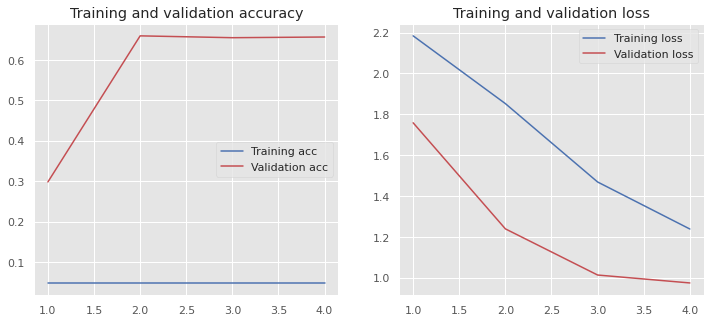

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy_train = history.history['accuracy']
    validation_accuracy_train = history.history['val_accuracy']
    loss_train = history.history['loss']
    validation_loss_train = history.history['val_loss']
    x = range(1, len(accuracy_train) + 1)

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy_train, 'b', label = 'Training acc')
    plt.plot(x, validation_accuracy_train, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss_train, 'b', label = 'Training loss')
    plt.plot(x, validation_loss_train, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(model_fitting)

In [ ]:
test = [j for i in test_docs for j in i]
dataset_test = pd.DataFrame(test, columns = ["Words", "Tags"])

In [ ]:
r = []
for i in range(len(test_docs)):
    x = len(test_docs[i])
    for j in range(x):
        r.append(i+1)

test_dataset["Sentence_idx"] = r

In [ ]:
class make_sentence(object):

  def __init__(self, dataset):
    self.sent = 1
    self.dataset = dataset
    self.empty = False
    func = lambda s : [(word, tag) for word, tag in zip(s["Words"].values.tolist(),
                                                        s["Tags"].values.tolist())]
    self.group = self.dataset.groupby("Sentence_idx").apply(func)
    self.sentences = [s for s in self.group]

  
  def get_max(self):
    try:
      s = self.group["Sentence : {}".format(self.sent)]
      self.sent += 1
      return s
    except :
      return None

In [ ]:
dataset_test.head()

,Words,Tags
0,Three-dimensional,B-Process
1,digital,I-Process
2,subtraction,I-Process
3,angiographic,I-Process
4,(,O


In [ ]:
getter = make_sentence(test_dataset)
sentences_test = getter.sentences

In [ ]:
dataset_test

,Words,Tags
0,Three-dimensional,B-Process
1,digital,I-Process
2,subtraction,I-Process
3,angiographic,I-Process
4,(,O
...,...,...
21128,magnetic,O
21129,moment,O
21130,of,O
21131,5×10−11μB,O


In [ ]:
from itertools import chain
count_tags = {}
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(train_dataset['Words'].to_list()))
    else:
        vocab = list(set(train_dataset['Tags'].to_list()))
        for i in vocab:
            if i not in count_tags:
                count_tags[i]=0
        for i in train_dataset['Tags'].to_list():
            count_tags[i] += 1
            
    for i in count_tags:
        print(i, count_tags[i])
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
        
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(dataset_test, 'token')
tag2idx, idx2tag = get_dict_map(dataset_test, 'tag')

B-Process 1849
I-Process 2309
I-Task 1831
I-Material 1363
B-Material 1409
B-Task 772
O 6115


In [ ]:
dataset_test.head()

,Words,Tags
0,Three-dimensional,B-Process
1,digital,I-Process
2,subtraction,I-Process
3,angiographic,I-Process
4,(,O


In [ ]:
dataset_test['Word_idx'] = dataset_test['Words'].map(w_to_i)
dataset_test['Tag_idx'] = dataset_test['Tags'].map(tag2idx)
dataset_test.head()

,Words,Tags,Word_idx,Tag_idx
0,Three-dimensional,B-Process,NaN,0
1,digital,I-Process,123911.0,1
2,subtraction,I-Process,346248.0,1
3,angiographic,I-Process,55258.0,1
4,(,O,158.0,6


In [ ]:
words_test = list(set(dataset_test["Words"].values))
words_test = list(dataset_test["Words"].values)
n_words_test = len(words_test)

tags_test = []
for tag_test in set(dataset_test["Tags"].values):
  if tag_test is nan or isinstance(tag_test, float):
    tags_test.append("Unknown")
  else:
    tags_test.append(tag_test)

n_tags_test  = len(tags_test)

In [ ]:
dataset_test

,Words,Tags,Word_idx,Tag_idx
0,Three-dimensional,B-Process,NaN,0
1,digital,I-Process,123911.0,1
2,subtraction,I-Process,346248.0,1
3,angiographic,I-Process,55258.0,1
4,(,O,158.0,6
...,...,...,...,...
21128,magnetic,O,230423.0,6
21129,moment,O,248238.0,6
21130,of,O,268046.0,6
21131,5×10−11μB,O,NaN,6


In [ ]:
train_dataset

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,Nuclear,B-Task,NaN,5,1
1,theory,I-Task,357607.0,2,1
2,devoted,O,122590.0,6,1
3,major,O,231345.0,6,1
4,efforts,O,133951.0,6,1
...,...,...,...,...,...
62424,derivatives.,I-Process,NaN,1,350
62449,one-,B-Process,NaN,0,350
62451,two-dimension,I-Process,NaN,1,350
62459,empirical,B-Material,136598.0,4,350


In [ ]:
r = []
for i in range(len(test_docs)):
    x = len(test_docs[i])
    for j in range(x):
        r.append(i+1)

dataset_test["Sentence_idx"] = r

In [ ]:
train_dataset

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,Nuclear,B-Task,NaN,5,1
1,theory,I-Task,357607.0,2,1
2,devoted,O,122590.0,6,1
3,major,O,231345.0,6,1
4,efforts,O,133951.0,6,1
...,...,...,...,...,...
62424,derivatives.,I-Process,NaN,1,350
62449,one-,B-Process,NaN,0,350
62451,two-dimension,I-Process,NaN,1,350
62459,empirical,B-Material,136598.0,4,350


In [ ]:
dataset_test

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,Three-dimensional,B-Process,NaN,0,1
1,digital,I-Process,123911.0,1,1
2,subtraction,I-Process,346248.0,1,1
3,angiographic,I-Process,55258.0,1,1
4,(,O,158.0,6,1
...,...,...,...,...,...
21128,magnetic,O,230423.0,6,100
21129,moment,O,248238.0,6,100
21130,of,O,268046.0,6,100
21131,5×10−11μB,O,NaN,6,100


In [ ]:
word2idx_test = {w: i for i, w in enumerate(words_test)}

tag2idx_test = tag2idx_train

#tag2idx_test = {t: i for i, t in enumerate(tags_test)}
idx2tag_test = {v: k for k, v in iteritems(tag2idx_test)}


In [ ]:
maxlen_test = 344

X_test = [[word2idx_test[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen = maxlen_test, sequences = X_test, padding = "post",value = n_words_test - 1)

Y_test = [[tag2idx_test[w[1]] for w in s] for s in sentences_test]
Y_test = pad_sequences(maxlen = maxlen_test, sequences = Y_test, padding = "post", value = 6)
Y_test = [to_categorical(i, num_classes = n_tags_test) for i in Y_test]

In [ ]:
def prediction(pred):
  output = []
  for i in pred:
    output_i = []
    for p in i:
      i = np.argmax(p)
      output_i.append(idx2tag_test[i])
    output.append(output_i)
  return output

pred_test = model.predict(X_test, verbose = 1)
labels_pred = prediction(pred_test)
labels_test = prediction(Y_test)

100/100 [==============================] - 5s 54ms/step


In [ ]:
print("F1-score: {:.1}".format(f1_score(labels_test, labels_pred)))

F1-score: 0.2


In [ ]:
train_dataset

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,Nuclear,B-Task,NaN,5,1
1,theory,I-Task,357607.0,2,1
2,devoted,O,122590.0,6,1
3,major,O,231345.0,6,1
4,efforts,O,133951.0,6,1
...,...,...,...,...,...
62424,derivatives.,I-Process,NaN,1,350
62449,one-,B-Process,NaN,0,350
62451,two-dimension,I-Process,NaN,1,350
62459,empirical,B-Material,136598.0,4,350


In [ ]:
dataset_test

,Words,Tags,Word_idx,Tag_idx,Sentence_idx
0,Three-dimensional,B-Process,NaN,0,1
1,digital,I-Process,123911.0,1,1
2,subtraction,I-Process,346248.0,1,1
3,angiographic,I-Process,55258.0,1,1
4,(,O,158.0,6,1
...,...,...,...,...,...
21128,magnetic,O,230423.0,6,100
21129,moment,O,248238.0,6,100
21130,of,O,268046.0,6,100
21131,5×10−11μB,O,NaN,6,100


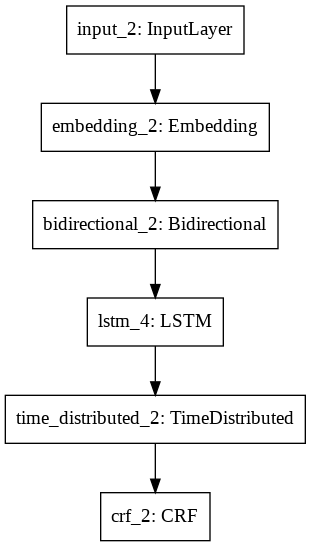

In [ ]:
plot_model(model)